# IMDB Sentiment Using Neural Networks
Collect the IMDB movie review datasets and use a deep learning model that will be trained and utilized to predict sentiment correctly

## Load Data

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
# import tensorflow as tf
# tf.config.experimental.set_visible_devices([], 'GPU')
import numpy as np
import pandas as pd

In [2]:
from keras.datasets import imdb

StartCharIndex = 1
OOVCharIndex = 2
WordIndexOffset = 3
UniqueWordMax = None
# UniqueWordMax = 5000 + WordIndexOffset - 1

(TrainX, TrainY), (TestX, TestY) = imdb.load_data(path="imdb.npz",
                                                  num_words = UniqueWordMax,
                                                  skip_top = 0,
                                                  maxlen = None,
                                                  seed = 13,
                                                  start_char = StartCharIndex,
                                                  oov_char = OOVCharIndex,
                                                  index_from = WordIndexOffset,
                                                 )

Using TensorFlow backend.


In [3]:
print(TrainX.shape)
print(TrainY.shape)

(25000,)
(25000,)


In [4]:
print(TestX.shape)
print(TestY.shape)

(25000,)
(25000,)


##### Merge datasets to get bigger training split

In [5]:
# TrainTestX = np.concatenate((TrainX, TestX), axis = 0)
# print(TrainTestX.shape)

In [6]:
# TrainTestY = np.concatenate((TrainY, TestY), axis = 0)
# print(TrainTestY.shape)

In [7]:
from sklearn.model_selection import train_test_split

TrainX, TestX, TrainY, TestY = train_test_split(np.concatenate((TrainX, TestX), axis = 0),
                                                np.concatenate((TrainY, TestY), axis = 0),
                                               test_size = 0.2,
                                               random_state = 13)

In [8]:
print(TrainX.shape)
print(TrainY.shape)

(40000,)
(40000,)


In [9]:
print(TestX.shape)
print(TestY.shape)

(10000,)
(10000,)


## Data Processing

In [10]:
import numpy as np
import pandas as pd

def GetArrayStats(ArrayData):
    resultsData = pd.DataFrame()
    resultsData = resultsData.append({
        "Stat": "Min",
        "Value": np.min(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Max",
        "Value": np.max(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Mean",
        "Value": np.mean(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Median",
        "Value": np.median(ArrayData),
    }, ignore_index = True)
    resultsData = resultsData.append({
        "Stat": "Std Dev",
        "Value": np.std(ArrayData),
    }, ignore_index = True)
    with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
        print(resultsData)
    return resultsData

In [11]:
# Sentiments, positive and negative
GetArrayStats(TrainY);
GetArrayStats(TestY);

      Stat     Value
0      Min  0.000000
1      Max  1.000000
2     Mean  0.499525
3   Median  0.000000
4  Std Dev  0.500000
      Stat     Value
0      Min  0.000000
1      Max  1.000000
2     Mean  0.501900
3   Median  1.000000
4  Std Dev  0.499996


In [12]:
print(np.max(np.hstack(TrainX)))
print(np.max(np.hstack(TestX)))

88586
88584


In [13]:
# Note: Some words are unique to Test set after the split due to low inherent word count
UniqueWordCounts = pd.Series(np.hstack(TrainX)).value_counts().drop([StartCharIndex, OOVCharIndex], axis = 0)
print(UniqueWordCounts)

4        533957
5        259659
6        258197
7        231256
8        214594
          ...  
68795         1
76991         1
52354         1
60550         1
72725         1
Length: 82468, dtype: int64


In [14]:
# Total count of words of potential interest
print(UniqueWordCounts.sum())

9355444


In [15]:
# Counts of word that occur more than 1% in the entire dataset
import pandas as pd
UniqueWordCounts.loc[UniqueWordCounts > (0.01 * UniqueWordCounts.sum())]

4     533957
5     259659
6     258197
7     231256
8     214594
9     169192
10    162103
11    149246
12    126088
13    123850
14    120591
15    109571
dtype: int64

In [16]:
type(UniqueWordCounts)

pandas.core.series.Series

In [17]:
TrainX_Reduced = [[word for word in row if (word in range(4, 16))] for row in TrainX]

In [18]:
pd.Series(np.hstack(TrainX_Reduced)).astype("int").value_counts()

4     533957
5     259659
6     258197
7     231256
8     214594
9     169192
10    162103
11    149246
12    126088
13    123850
14    120591
15    109571
dtype: int64

### Pad/Truncate review text strings to uniform length

#### Determine a good length cutoff

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
TrainX_RowLengths = [len(row) for row in TrainX_Reduced]

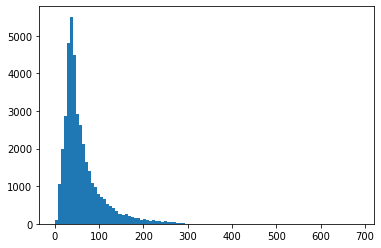

In [21]:
plt.close("all")
plt.hist(TrainX_RowLengths, bins = 100)
plt.show()

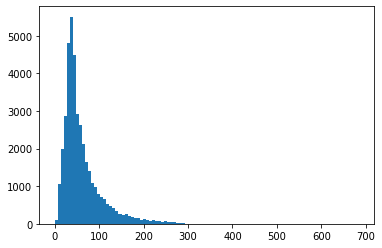

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.close("all")
plt.hist([len(row) - 1 for row in TrainX_Reduced], bins = 100)
plt.show()

In [22]:
print(np.max(TrainX_RowLengths))

686


In [82]:
# Calculate mean + 3*standard deviation word count
print(np.mean([len(row) for row in (TrainX_Reduced)]) - 3 * np.std([len(row) for row in TrainX_Reduced]))
print(np.mean([len(row) for row in TrainX_Reduced]) + 3 * np.std([len(row) for row in TrainX_Reduced]))

-73.78597700149756
196.70117700149757


#### Rescale to log of row lengths

In [89]:
TrainX_RowLengths = [np.log(len(row) + 1) for row in TrainX_Reduced]

In [92]:
pd.Series(TrainX_RowLengths).describe()

count    40000.000000
mean         3.926211
std          0.641117
min          0.000000
25%          3.526361
50%          3.871201
75%          4.330733
max          6.532334
dtype: float64

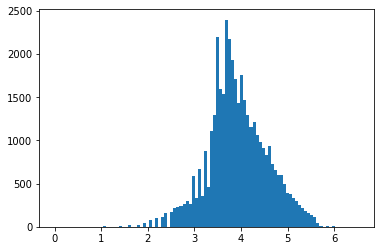

In [84]:
plt.close("all")
plt.hist([np.log(len(row) + 1) for row in TrainX_Reduced], bins = 100)
plt.show()

In [81]:
# Calculate mean + 3*standard deviation word count
print(np.mean([np.log(len(row) + 1) for row in (TrainX_Reduced)]) - 3 * np.std([np.log(len(row) + 1) for row in TrainX_Reduced]))
print(np.mean([np.log(len(row) + 1) for row in TrainX_Reduced]) + 3 * np.std([np.log(len(row) + 1) for row in TrainX_Reduced]))

2.0028849555375516
5.849536300184907


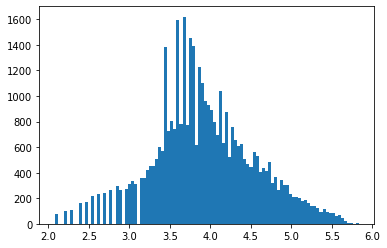

In [85]:
plt.close("all")
plt.hist([np.log(len(row) + 1) for row in TrainX_Reduced if (np.log(len(row) + 1) > 2 and np.log(len(row) + 1) < 5.85)], bins = 100)
plt.show()

In [86]:
pd.Series([np.log(len(row) + 1) for row in TrainX_Reduced if (np.log(len(row) + 1) > 2 and np.log(len(row) + 1) < 5.85)]).describe()

count    39879.000000
mean         3.931340
std          0.629993
min          2.079442
25%          3.526361
50%          3.871201
75%          4.330733
max          5.834811
dtype: float64

In [87]:
# Calculate mean + 6*standard deviation word count
print(np.mean([np.log(len(row) + 1) for row in TrainX_Reduced]) - 6 * np.std([np.log(len(row) + 1) for row in TrainX_Reduced]))
print(np.mean([np.log(len(row) + 1) for row in TrainX_Reduced]) + 6 * np.std([np.log(len(row) + 1) for row in TrainX_Reduced]))

0.07955928321387384
7.772861972508585


In [88]:
pd.Series([np.log(len(row) + 1) for row in TrainX_Reduced if (np.log(len(row) + 1) > 0.07 and np.log(len(row) + 1) < 7.77)]).describe()

count    39999.000000
mean         3.926309
std          0.640824
min          0.693147
25%          3.526361
50%          3.871201
75%          4.330733
max          6.532334
dtype: float64

In [99]:
from mpl_toolkits.mplot3d import Axes3D

figure = plt.figure()
axes = fig.add_subplot(111, projection = "3d")


In [ ]:
RowLengths = [len(row) for row in TrainX_Reduced]

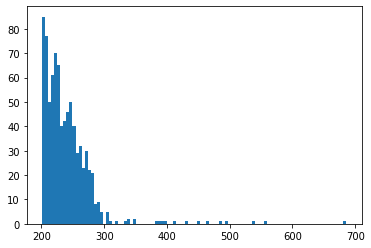

In [97]:
plt.close("all")
plt.hist([len(row) for row in TrainX_Reduced if (len(row) > 200)], bins = 100)
plt.show()

In [98]:
len([len(row) for row in TrainX_Reduced if (len(row) > 200)])

830

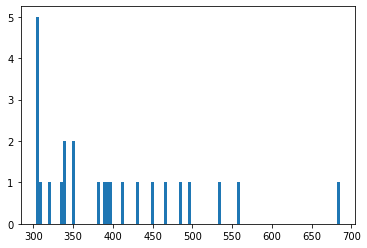

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.close("all")
plt.hist([len(row) for row in TrainX_Reduced if (len(row) > 300)], bins = 100)
plt.show()

In [95]:
len([len(row) for row in TrainX_Reduced if (len(row) > 300)])

25

In [96]:
len([len(row) for row in TrainX_Reduced if (len(row) > 300)]) / len(TrainX_Reduced)

0.000625

In [37]:
# Calculate mean + 3*standard deviation word count
print(np.mean([len(row) - 1 for row in TrainTestX]) + 3 * np.std([len(row) - 1 for row in TrainTestX]))

752.493403762071


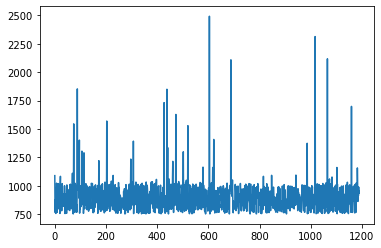

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.close("all")
plt.plot(range(len([len(row) - 1 for row in TrainTestX if len(row) > 752])), [len(row) - 1 for row in TrainTestX if len(row) > 752])
plt.show()

In [30]:
# Calculate mean + 3*standard deviation word count
print(np.mean([len(row) - 1 for row in TrainTestX]) + 5 * np.std([len(row) - 1 for row in TrainTestX]))

1098.3163929367852


23


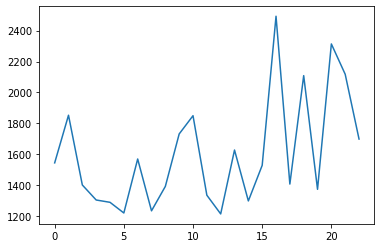

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

print(len([len(row) - 1 for row in TrainTestX if len(row) > 1198]))
plt.close("all")
plt.plot(range(len([len(row) - 1 for row in TrainTestX if len(row) > 1198])), [len(row) - 1 for row in TrainTestX if len(row) > 1198])
plt.show()

In [36]:
# Calculate mean + 3*standard deviation word count
print(np.mean([len(row) - 1 for row in TrainTestX]) + 6 * np.std([len(row) - 1 for row in TrainTestX]))

1271.227887524142


In [21]:
# Calculate median + 3*standard deviation word count
GetArrayStats([len(row) - 1 for row in TrainTestX])

      Stat        Value
0      Min     6.000000
1      Max  2493.000000
2     Mean   233.758920
3   Median   175.000000
4  Std Dev   172.911495


,Stat,Value
0,Min,6.000000
1,Max,2493.000000
2,Mean,233.758920
3,Median,175.000000
4,Std Dev,172.911495


In [22]:
# Calculate median + 3*standard deviation word count
GetArrayStats([len(row) for row in TrainTestX_Filtered])

      Stat       Value
0      Min    0.000000
1      Max  633.000000
2     Mean   58.673260
3   Median   45.000000
4  Std Dev   42.749797


,Stat,Value
0,Min,0.000000
1,Max,633.000000
2,Mean,58.673260
3,Median,45.000000
4,Std Dev,42.749797


In [23]:
ReviewTextLengthMax = int(np.median([len(row) - 1 for row in TrainTestX]) + 3 * np.std([len(row) - 1 for row in TrainTestX]))
ReviewTextLengthMax

686

#### Pad short rows and truncate longer rows

In [25]:
from keras.preprocessing import sequence
TrainTestX = sequence.pad_sequences(TrainTestX, maxlen = ReviewTextLengthMax, value = 0, padding = "post")

In [154]:
print(TrainTestX.shape)
print(TrainTestX)

(50000, 172)
[[13 14 13 ...  0  0  0]
 [ 9 11  4 ...  0  0  0]
 [14  4  7 ...  0  0  0]
 ...
 [ 8  7  6 ...  0  0  0]
 [13  8 14 ...  0  0  0]
 [13 14  9 ...  0  0  0]]


## Split train-test data

In [142]:
from sklearn.model_selection import train_test_split
TrainX, TestX, TrainY, TestY = train_test_split(TrainTestX, TrainTestY, test_size = 0.2, random_state = 13)

In [143]:
print(TrainX.shape)
print(TrainY.shape)

(40000, 693)
(40000,)


In [144]:
print(TestX.shape)
print(TestY.shape)

(10000, 693)
(10000,)


In [145]:
# TrainData = np.reshape(TrainX, [-1, 1, TrainX.shape[1]])
# TestData = np.reshape(TestX, [-1, 1, TrainX.shape[1]])
TrainData = TrainX
TestData = TestX

In [146]:
TrainData.shape

(40000, 693)

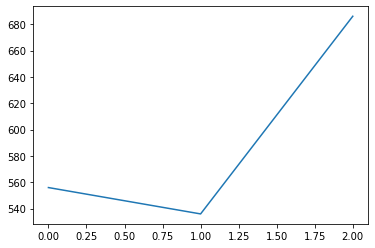

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.close("all")
plt.plot(range(len([len(row) for row in TrainX_Reduced if len(row) > 500])), [len(row) for row in TrainX_Reduced if len(row) > 500])
plt.show()

In [68]:
[len(row) for row in TrainX_Reduced if len(row) > 500]

[556, 536, 686]

In [34]:
TrainX[0].shape

(693,)

In [35]:
TestData.shape

(10000, 693)

In [75]:
# Calculate mean + 6*standard deviation word count
print(np.mean([len(row) for row in TrainX_Reduced]) + 6 * np.std([len(row) for row in TrainX_Reduced]))

331.9447540029951


In [36]:
TrainY.shape

(40000,)

In [37]:
# from keras.utils.np_utils import to_categorical
# TrainTarget = to_categorical(TrainY)
# TestTarget = to_categorical(TestY)
TrainTarget = TrainY
TestTarget = TestY

In [38]:
TrainTarget.shape

(40000,)

In [39]:
TestTarget.shape

(10000,)

## Setup Neural Network

In [ ]:
InputShape = (1, TrainX.shape[1])
InputSize = TrainX.shape[1]
print(InputShape)
print(InputSize)
BatchSize = 128
KernelSize = 4
PoolSize = 2
Filters = 64
HiddenUnitsCount = 256
DropoutRate = 0.2
LabelCount = 1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import SimpleRNN
from keras.optimizers import SGD, RMSprop, Adam

def CreateRNN():
    keras.backend.clear_session()
    model = Sequential()
    # Input Layer
    model.add(Embedding(UniqueWordMax, 32, input_length = InputSize))
    model.add(SimpleRNN(units = HiddenUnitsCount, dropout = DropoutRate, input_shape = InputShape))
    # Hidden Layer
    model.add(Dense(HiddenUnitsCount))
    model.add(Activation("tanh"))
    # Output Layer
    model.add(Dense(LabelCount))
    model.add(Activation("sigmoid"))
    
    model.compile(loss = "binary_crossentropy",
                 optimizer = SGD(),
                 metrics = ["accuracy"])
    return model

## Run network models and determine accuracy

### Simple RNN

In [ ]:
model = CreateRNN()
model.summary()

In [86]:
pd.Series([np.log(len(row) + 1) for row in TrainX_Reduced if (np.log(len(row) + 1) > 2 and np.log(len(row) + 1) < 5.85)]).describe()

count    39879.000000
mean         3.931340
std          0.629993
min          2.079442
25%          3.526361
50%          3.871201
75%          4.330733
max          5.834811
dtype: float64

In [ ]:
model.fit(TrainData, TrainTarget, validation_data = (TestData, TestTarget), epochs = 15, batch_size = BatchSize, verbose = 2)

In [ ]:
TestPredictions = model.predict(TestData)

In [ ]:
TestPredictions

In [73]:
len(TrainX_Reduced)

40000

In [ ]:
GetArrayStats([TestTarget]);
GetArrayStats([TestPredictions]);

In [ ]:
TestTarget[:20]

In [60]:
# Mean + 3*standard deviation word count
print(np.mean([len(row) for row in TrainX_Reduced]) + 3 * np.std([len(row) - 1 for row in TrainX_Reduced]))

196.70117700149757


In [63]:
# Mean + 6*standard deviation word count
print(np.mean([len(row) for row in TrainX_Reduced]) + 6 * np.std([len(row) - 1 for row in TrainX_Reduced]))

331.9447540029951


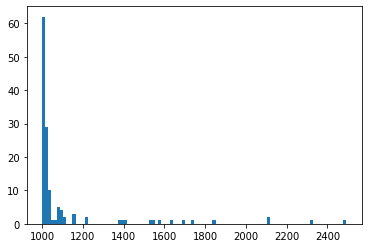

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.close("all")
plt.hist([len(row) - 1 for row in TrainX if len(row) > 1000], bins = 100)
plt.show()

In [ ]:
(TestPredictions.reshape(-1, ) >= 0.5).astype(int)[:20]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [ ]:
accuracy_score(TestTarget, (TestPredictions >= 0.5).astype(int))

In [ ]:
accuracy_score(TestTarget, TestPredictions)

### Simple LSTM

In [ ]:
InputShape = (1, TrainX.shape[1])
InputSize = TrainX.shape[1]
print(InputShape)
print(InputSize)
BatchSize = 128
KernelSize = 4
PoolSize = 2
Filters = 64
HiddenUnitsCount = 256
DropoutRate = 0.2
LabelCount = 1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM
#from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Conv1D, MaxPool1D, Flatten
from keras.optimizers import SGD, RMSprop, Adam

def CreateLSTM():
    keras.backend.clear_session()
    model = Sequential()
    # Input Layer
    model.add(Embedding(UniqueWordMax, 32, input_length = InputSize))
    model.add(LSTM(units = HiddenUnitsCount, dropout = DropoutRate, input_shape = InputShape, return_sequences = True))
    model.add(Activation("softmax"))
    model.add(LSTM(units = HiddenUnitsCount, dropout = DropoutRate, input_shape = InputShape))
    model.add(Activation("softmax"))
#     model.add(LSTM(100))
#     model.add(Dropout(DropoutRate))
#     model.add(Activation("relu"))
    # Hidden Layer
#     model.add(Dense(800))
#     model.add(LSTM(10))
#     model.add(Dropout(DropoutRate))
#     model.add(Activation("relu"))
    # Output Layer
    model.add(Dense(LabelCount))
    model.add(Activation("sigmoid"))
    
    model.compile(loss = "binary_crossentropy",
                 optimizer = Adam(),
                 metrics = ["accuracy"])
    return model

In [ ]:
model = CreateLSTM()
model.summary()

In [ ]:
model.fit(TrainData, TrainTarget, validation_data = (TestData, TestTarget), epochs = 15, batch_size = BatchSize, verbose = 2)

In [ ]:
TestPredictions = model.predict(TestData)

In [ ]:
TestPredictions

In [ ]:
GetArrayStats([TestTarget]);
GetArrayStats([TestPredictions]);

In [ ]:
(TestPredictions.reshape(-1, ) >= 0.5).astype(int)[:20]

In [ ]:
TestTarget[:20]

In [ ]:
accuracy_score(TestTarget, (TestPredictions >= 0.5).astype(int))

## Simple Multi Layer Perceptron

In [79]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Flatten
from keras.optimizers import SGD, Adam

InputShape = (1, TrainX.shape[1])
InputSize = TrainX.shape[1]
print("InputShape: " , InputShape)
print("InputSize: ", InputSize)
BatchSize = 128
InputUnitsCount = 64
HiddenUnitsCount = 128
KernelSize = 4
DropoutRate = 0.2
LabelCount = 1

def CreateMLP():
    keras.backend.clear_session()
    model = Sequential()
    
    # Input layer
    model.add(Dense(InputUnitsCount, input_dim = InputSize))
#     model.add(Embedding(UniqueWordMax, 32, input_length = InputSize))
#     model.add(Embedding(InputUnitsCount, 32, input_length = InputSize))
#     model.add(Flatten())
#     model.add(Dense(100))
    model.add(Activation("relu"))
    # Hidden Layer 1
    model.add(Dense(100))
    model.add(Activation("relu"))
    
    # Output layer
    model.add(Dense(LabelCount, activation = "sigmoid"))
    
    model.compile(
        loss = "binary_crossentropy",
        optimizer = Adam(),
        metrics = ["accuracy"]
    )
    
    return model

def CreateMLPWithEmbedding():
    keras.backend.clear_session()
    model = Sequential()
    
    # Input layer
    model.add(Embedding(input_dim = UniqueWordMax, output_dim = 32, input_length = InputSize))
#     model.add(Embedding(input_dim = InputSize, output_dim = KernelSize, input_length = InputSize))
#     model.add(Embedding(input_dim = InputUnitsCount, output_dim = KernelSize, input_length = InputSize))
    model.add(Flatten())
    model.add(Dense(InputUnitsCount))
#     model.add(Dense(InputSize))
#    model.add(Dropout(DropoutRate))
    model.add(Activation("relu"))
    # Hidden Layer 1
    model.add(Dense(InputUnitsCount))
#    model.add(Dropout(DropoutRate))
    model.add(Activation("relu"))
    
    # Output layer
    model.add(Dense(LabelCount, activation = "sigmoid"))
    
    model.compile(
        loss = "binary_crossentropy",
        optimizer = Adam(),
        metrics = ["accuracy"]
    )
    
    return model

InputShape:  (1, 693)
InputSize:  693


In [83]:
model = CreateMLPWithEmbedding()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 693, 32)           2834720   
_________________________________________________________________
flatten_1 (Flatten)          (None, 22176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1419328   
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [84]:
model.fit(TrainData, TrainTarget, validation_data = (TestData, TestTarget), epochs = 5, batch_size = BatchSize, verbose = 2)

C:\ProgramData\Anaconda3\envs\DataScience\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
 - 3s - loss: 0.4058 - accuracy: 0.7954 - val_loss: 0.2576 - val_accuracy: 0.8928
Epoch 2/5
 - 3s - loss: 0.1240 - accuracy: 0.9567 - val_loss: 0.3295 - val_accuracy: 0.8774
Epoch 3/5
 - 3s - loss: 0.0212 - accuracy: 0.9949 - val_loss: 0.4278 - val_accuracy: 0.8791
Epoch 4/5
 - 3s - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.4937 - val_accuracy: 0.8817
Epoch 5/5
 - 3s - loss: 4.1368e-04 - accuracy: 1.0000 - val_loss: 0.5472 - val_accuracy: 0.8837


In [82]:
TestPredictions = model.predict(TestData)

In [ ]:
TestPredictions

In [ ]:
GetArrayStats([TestTarget]);
GetArrayStats([TestPredictions]);

In [ ]:
TestPredictions.reshape(-1, )[:20]

In [ ]:
(TestPredictions.reshape(-1, ) >= 0.5).astype(int)[:20]

In [ ]:
TestTarget[:20]

In [ ]:
accuracy_score(TestTarget, (TestPredictions >= 0.5).astype(int))

### Index-Word mappings

In [60]:
WordIndex = imdb.get_word_index()
ReverseWordIndex = dict([(value, key) for (key, value) in WordIndex.items()])

In [61]:
print(len(WordIndex))

88584


In [62]:
WordIndex

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [63]:
ReverseWordIndex

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [69]:
[print(review, "\n") for review in [" ".join([ReverseWordIndex.get(i-WordIndexOffset, "#") for i in TrainTestX[r]]) for r in range(20)]]

# ok i adore this film i will credit this movie alone for making me such a die hard horror fanatic i could never watch this movie alone i've also heard many many stories of the effect it had in it's original release at the theatres on its viewers incredible masterpiece horrible psychological stuff scares the pants off me oh bless their hearts whoever made this awesome film i love it i thought the whole film was decent and interesting this movie is so scary this is the scariest movie i have ever seen in my life not that what happens in the film and the idea of the film are not scary enough but what always got me was brendan's fabulous acting best horror film ever nothing can ever be this scary again halloween viewing at its evilest 

# pre adolescent humor is present in large quantities the acting and story are wonderful if you can stomach the concept those with weak constitutions will have some difficulty since the worms are realistic enough to cause churning of more than a few in the 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]